In [1]:
from skimage import io, color, exposure, filters, transform
from skimage.morphology import binary_erosion, binary_dilation
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops, label
from skimage.filters import sobel 
from skimage.color import rgb2hsv

from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import sklearn_crfsuite
from sklearn.metrics import make_scorer
#from sklearn.cross_validation import cross_val_score
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import matplotlib.pyplot as plt

import numpy as np

from scipy import ndimage as ndi
from scipy import ndimage


In [2]:
#DISPLAY IMAGE
def show_image(img, grayscale=False):
    if grayscale:
        plt.imshow(img, cmap=plt.cm.gray)
    else:
        plt.imshow(img)
    plt.show()

In [3]:
#VARIOUS TRANSFORMATIONS ON ORIGINAL IMAGE
def transform_image(img):
    #turning image to gray and inverting it
    print("Original")
    show_image(img)
    
    grayscale = color.rgb2gray(img)
    
    inverted = 1 - grayscale
    print("Inverted")
    show_image(inverted, True)

    inverted = exposure.equalize_adapthist(inverted)
    print("Inverted equalized")
    show_image(inverted, True)

    print("Sobel")
    show_image(sobel(inverted))
    sobeled = sobel(inverted)
    inverted = inverted - sobeled
    print("Inverted - Sobel")
    show_image(inverted)
    #various image transformation in order to get the best representation
    threshold = filters.threshold_mean(inverted)
    binarized = inverted > threshold + 0.2

    eroded = binary_erosion(binarized)
    eroded = binary_erosion(eroded) #applied two times to get better results

    filled = ndimage.binary_fill_holes(eroded) #this image will later be used 

    eroded = binary_erosion(filled) #again

    scaled = transform.resize(filled, (128, 128), anti_aliasing=False)

    #showing various images to compare the results of transformations
    print('Grayscale')
    show_image(grayscale, True)
    print("Binarized")
    show_image(binarized, True)
    print("Erroded 3 times")
    show_image(eroded, True)
    print("Filled - binary fill, ")
    show_image(filled, True)
    print("Scaled on 128x128")
    show_image(scaled, True)
    
    return filled

In [4]:
#In order to be able to use image in a proper way 
def img_to_array(img, toNum = False):
    if not toNum:
        return np.array([img[i,j] for i in range(img.shape[0]) for j in range(img.shape[1])])
    tmp = np.array([img[i,j] for i in range(img.shape[0]) for j in range(img.shape[1])])
    return [1 if x == True else 0 for x in tmp]

In [5]:
def pixel_features(pixel):
    #HSV
    hsv_pix = rgb2hsv(pixel) #np.matrix([[pixel]])
    hue_pix = hsv_pix[0]
    sat_pix = hsv_pix[1]
    value_pix = hsv_pix[2] #luminosity
    return {
        'hue': hue_pix,
        'saturation': sat_pix,
        'value': value_pix,
    }


In [6]:
def image_to_features(image, pic_width, pic_height):
    print(pic_width, pic_height)
    image_array = img_to_array(image);
    all_features = []
    for i in range(image_array.shape[0]):
        pixel = pixel_features(image_array[i])
        features = {
            'hue': pixel['hue'],
            'saturation': pixel['saturation'],
            'value': pixel['value']
        }
        if i % pic_width != 0:
            #not on left edge
            pixel = pixel_features(image_array[i - 1])
            features.update({
                '-1:hue': pixel['hue'],
                '-1:saturation':  pixel['saturation'],
                '-1:value': pixel['value']
            })
            
        if i % pic_width != pic_width-1:
            #not right edge
            pixel = pixel_features(image_array[i + 1])
            features.update({
                '+1:hue': pixel['hue'],
                '+1:saturation':  pixel['saturation'],
                '+1:value': pixel['value']
            })
        if i >= pic_width:
            #not upper edge
            pixel = pixel_features(image_array[i - pic_width])
            features.update({
                f'-{pic_width}:hue': pixel['hue'],
                f'-{pic_width}:saturation':  pixel['saturation'],
                f'-{pic_width}:value': pixel['value']
            })
        if i < (pic_height - 1) * pic_width:
            #not bottom edge 
            pixel = pixel_features(image_array[i + pic_width])
            features.update({
                f'+{pic_width}:hue': pixel['hue'],
                f'+{pic_width}:saturation': pixel['saturation'],
                f'+{pic_width}:value': pixel['value']
            })
            
        all_features.append([features])
    return all_features

In [8]:
def calculate_crf(path):
    img = io.imread(path)
    img_orig = io.imread(path)

    filled = transform_image(img) #getting filled image 

    featured_image = image_to_features(img, img.shape[0], img.shape[1]) #img_orig
    filled_to_array = img_to_array(filled, toNum=True)
    filled_to_num = [[f'{x}'] for x in filled_to_array]

    X_train, X_test, Y_train, Y_test = train_test_split(featured_image, filled_to_num, test_size=0.33, random_state=42)
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1, 
        c2=0.1, 
        max_iterations=20,
        all_possible_transitions=False,
    )
    crf.fit(X_train, Y_train);

    labels = list(crf.classes_)
    print("Classes: ",labels)

    Y_pred = crf.predict(X_test)
    metrics.flat_f1_score(Y_test, Y_pred,
                          average='weighted', labels=labels)
    sorted_labels = sorted(
        labels,
        key=lambda name: (name[1:], name[0])
    )
    print(metrics.flat_classification_report(
        Y_test, Y_pred, labels=sorted_labels, digits=3
    ))
    
    return crf

Original


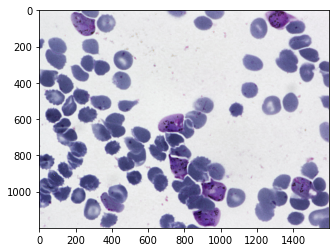

Inverted


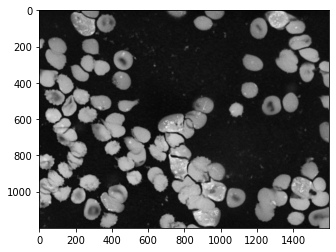

Inverted equalized


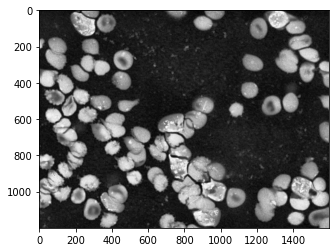

Sobel


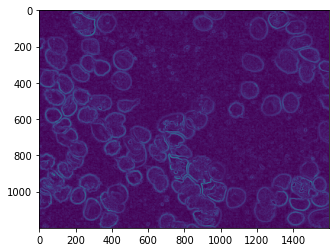

Inverted - Sobel


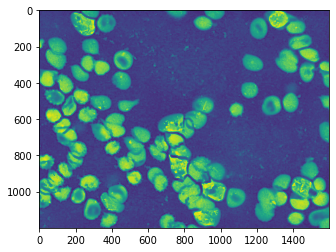

Grayscale


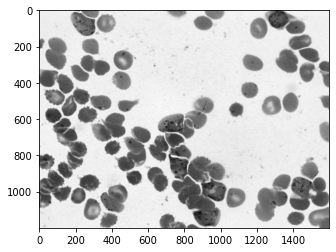

Binarized


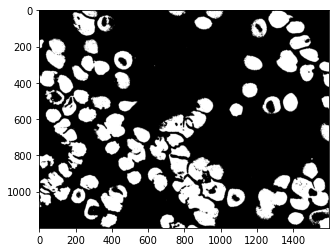

Erroded 3 times


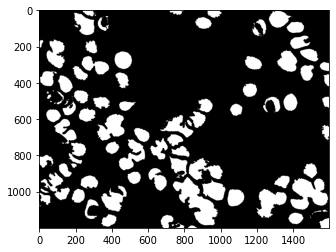

Filled - binary fill, 


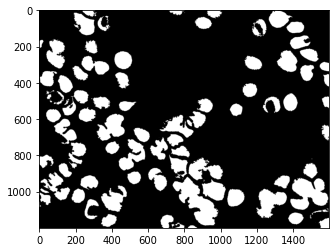

Scaled on 128x128


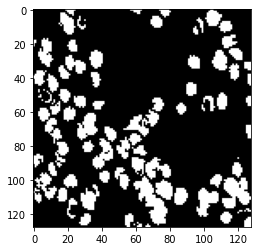

1200 1600
Classes:  ['0', '1']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['0', '1'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

           0      0.968     0.953     0.960    488247
           1      0.849     0.894     0.871    145353

    accuracy                          0.939    633600
   macro avg      0.909     0.923     0.916    633600
weighted avg      0.941     0.939     0.940    633600



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=20)

In [9]:
path = 'images/0dcbf2c9-f959-4703-a72b-f6a81e66c2ea.png';
calculate_crf(path)

In [ ]:
#skaliraj slike na 400 x 400